# Week 7: Sentiment Classification with Pre-trained GloVe Embeddings

In this notebook, we’ll build two simple neural models that use **GloVe embeddings** in a **BOE** (Bag of Embeddings) language model to classify movie reviews as positive or negative.

#### About the GloVe training data  
The “6B” pre-trained models (50d, 100d, 200d, 300d) were built from a **6 billion-token** corpus consisting of:  
- **Wikipedia 2014 dump** (~ 1 billion tokens)  
- **Gigaword 5 newswire** (~ 5 billion tokens)  

GloVe also offers larger variants trained on Common Crawl:  
- **42B** (42 billion tokens)  
- **840B** (840 billion tokens)

You can download the 6B vectors here:   <http://nlp.stanford.edu/data/glove.6B.zip>. Inside you’ll find:

```
glove.6B.50d.txt
glove.6B.100d.txt    ← we’ll use this one
glove.6B.200d.txt
glove.6B.300d.txt

```

The number before the “d” is the **embedding dimensionality**—i.e., the length of each word vector:

- **Smaller dims** (50, 100) use less memory and train faster, but may miss subtle semantic nuances.  
- **Larger dims** (200, 300) capture richer relationships at the cost of more parameters (e.g. 300 × vocabulary_size floats) and slower training.

Choose your vector size as a trade-off between representational power and computational efficiency.


In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import random

from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

from collections import Counter

# Reproducibility

random_seed = 42

# This reduces the uncertainty but doesn't completely eliminate it

# 1) OS-level: try to make operations deterministic
os.environ['PYTHONHASHSEED'] = '0'        # disable hash randomization
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # TensorFlow deterministic ops
os.environ['TF_CUDNN_DETERMINISM'] = '1'  # if using GPU/CuDNN

random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# utility code

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

'''  How to time your code
# start timer
start_time = time.time()

<your code here> 

# Record end time and print execution time
print(f"Execution Time: " + format_time(time.time()-start_time))
'''

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

In [8]:
def plot_learning_curves(hist, title="Learning Curves", verbose=True):

    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    n_epochs = len(val_losses)
    epochs = list(range(1, n_epochs + 1))

    # Determine tick interval and xticks starting from 0

    tick_interval = max(1, n_epochs // 20)
    xticks = list(range(0, n_epochs + 1, tick_interval))

    plt.figure(figsize=(8, 8))

    # --- Loss Plot ---
    plt.subplot(2, 1, 1)
    plt.plot(epochs, hist.history['loss'], label='Train Loss')
    plt.plot(epochs, hist.history['val_loss'], label='Val Loss')
    plt.scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='Min Val Loss')
    plt.title(f'{title} - Loss')
    plt.ylabel('Loss')
    plt.xticks(xticks)
    plt.legend()
    plt.grid(True)

    # --- Accuracy Plot ---
    plt.subplot(2, 1, 2)
    plt.plot(epochs, hist.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, hist.history['val_accuracy'], label='Val Accuracy')
    plt.scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='Acc @ Min Val Loss')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    # plt.ylim(0, 1.05)
    plt.xticks(xticks)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

#### Load the IMDb dataset

**Token IDs**

The reviews in the dataset are stored using integer **token IDs** in the range $[0\ldots 88,588]$ for **88,585 unique words** plus three special tokens
used by Keras:

```

0: '<PAD>'    Used to pad reviews shorter than the max length
1: '<START>'  Marks the start of each review
2: '<OOV>'    Replaces any word Outside Of our chosen Vocabulary

```

After these comes an unused slot (for obscure historical reasons), and then the "real words" of the reviews in descending order of frequency:

```
3: --unused--
4: the               (the most-frequent word)
5: and     
6: a       

...

88,586: artbox
88,587: voorhees'
88,588: 'l'           (the least-frequent word)

```

For example, a review that started **"And the Voorhees' artbox ..."** would be encoded as:

    1  5  4  88587  88586 ...

**Word Indices**

The dataset also comes with a method `get_word_index()` which returns a dictionary mapping real words to their index in decreasing order of frequency, but starting at 1:

    word_index = imdb.get_word_index()    
    word_index["the"]  =>  1
    word_index["and"]  =>  2

Thus, for real words, the **token ID = word index + 3**. 

**Restricting the Vocabulary**

It is usually preferable to **restrict the vocabulary** so that only the most frequent words are retained, to
- improve embedding coverage,
- reduce model size and overfitting risk, and
- speed up both training and inference.

To restrict the vocabulary to size `N` when loading the dataset, we use the parameter `num_words = N`, which keeps token IDs $[0\ldots N-1]$ but
replaces any token ID $\ge N$ with 2 = `<OOV>`. Thus, we keep the three special tokens, plus N-4 real words, plus the unused ID, which never occurs
in any review. 

If N = 20,000, our sample review above would start:

    1  5  4  2  2  ...



In [22]:
training_vocabulary_size = 20_000    # Cool, Python ignores underscores in integers, so you can use this for 20,000 for readability 

(X_tr, y_tr), (X_te, y_te) = imdb.load_data( num_words = training_vocabulary_size )     # use imdb.load_data() to load all words     

#### Train-Test Split

The dataset as we download it is pre-split 50 : 50 into training and testing sets. We prefer to use the more standard 80 : 20 split, so we'll combine and do our own split, stratifying as usual for classification. 

In [23]:
X  = np.concatenate([X_tr, X_te], axis=0)
y  = np.concatenate([y_tr, y_te], axis=0)

print(f"Total samples: {len(X)}") 

# 80 / 20 stratified split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=random_seed,
    stratify=y
)
print(f"Train samples: {len(X_train)},  Test samples: {len(X_test)}")  

Total samples: 50000
Train samples: 40000,  Test samples: 10000


#### Check if the dataset is balanced (yup!)

In [24]:
Counter(y)

Counter({1: 25000, 0: 25000})

#### Set Sample Length 

Reviews are of different lengths, but a neural network needs fixed-length inputs, so we need to 
- **Define a maximum length**,
- Truncate the longer ones, and
- Pad the shorter ones.

In order to be *extra-extra-extra careful* of data leakage, we'll 
- Look at a histogram of the lengths of the reviews in the **training set only**,
- Decide on our `max_text_length` cutoff, and
- Apply that cutoff to the training and testing set. 

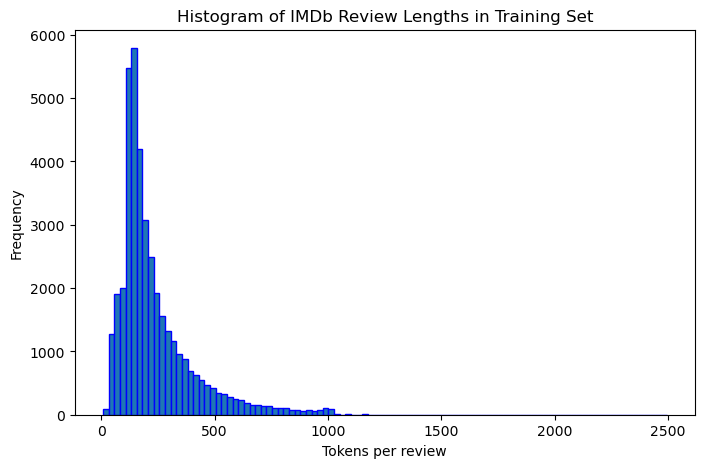

In [25]:
# Draw histogram of training set lengths

plt.figure(figsize=(8, 5))
plt.hist( [len(r) for r in X_train], bins=100, edgecolor='b')      
plt.title("Histogram of IMDb Review Lengths in Training Set")
plt.xlabel("Tokens per review")
plt.ylabel("Frequency")
plt.show()

In [26]:
# Set maximum review length and pad/truncate sequences

max_text_length = 500

X_train = pad_sequences(
    X_train,
    maxlen=max_text_length,
    padding='post',     # pad with zeros at end of each sequence < max_text_length; 'pre' would pad at beginning
    truncating='post'   # drop tokens at end if sequence > max_text_length; 'pre' would drop tokens at beginning
)

X_test = pad_sequences(
    X_test,
    maxlen=max_text_length,
    padding='post',
    truncating='post'
)

print(X_train.shape, X_train.dtype)

(40000, 500) int32


#### Now get the `word_index` dictionary 

We will also create a reverse token ID → word dictionary just to show a sample message. 

In [27]:

word_index      = imdb.get_word_index()

print(f"The word index for 'and' is {word_index['and']}.\n")

# Reverse lookup table  token ID → word
tokenID_word = { idx + 3 : w for w, idx in word_index.items()}             # +3 offset (Keras special tokens)
tokenID_word[0] = '<PAD>'
tokenID_word[1] = '<START>'
tokenID_word[2] = '<OOV>'

def decode(review):
    return " ".join(tokenID_word[i] for i in review)

sample_len = 12
print(f"Here are the first {sample_len} token in the first review, as token IDs and as words:")
print()
print(X_train[0][:sample_len])
print()
print(decode(X_train[0][:sample_len]))

The word index for 'and' is 2.

Here are the first 12 token in the first review, as token IDs and as words:

[    1   103   149     2     4 10755    34  2695  4334    13   872     8]

<START> after watching <OOV> the velvet by sarah waters i decided to


Notice that all words are in lower case and punctuation has been removed. The first review originally started:

        After watching Tipping the Velvet by Sarah Waters, I decided to ...

The one punctuation‐like token that often survives is `br` (a remnant of the original HTML line-break tag `<br />`). It’s treated as an ordinary word and given its own token ID.

Contractions are split on the apostrophe, so you’ll get “didn” + “t”, “isn” + “t”, etc. (because the apostrophe was stripped).

#### Load the GLoVe vectors

In [28]:
embedding_dimension = d             # adjust dimension if needed

glove_path = Path(f"glove.6B.{embedding_dimension}d.txt")  

embeddings_index = {}
with glove_path.open(encoding='utf8') as f:
    for line in f:
        word, *vec = line.split()
        embeddings_index[word] = np.asarray(vec, dtype='float32')

print(f"GloVe words loaded: {len(embeddings_index):,}")

GloVe words loaded: 400,000


Let's look at the actual encoding of the word "after" in the 100-dimensional encoding space:

In [29]:
# Retrieve the 100-dimensional vector for "after"
vec = embeddings_index.get('after')

print(f"GLoVe embedding of \"after\" in {embedding_dimension} dimensions:\n")
print(vec)

GLoVe embedding of "after" in 100 dimensions:

[ 3.7711e-01 -3.4471e-01  1.3405e-01 -1.1710e-02 -1.9427e-01  4.1464e-01
  4.0608e-01  4.3063e-01 -5.7060e-02 -1.9921e-01  4.3267e-01 -1.6269e-02
  2.1710e-01 -2.6149e-03  3.9424e-01 -4.2803e-01 -1.7495e-02 -5.6658e-01
 -4.4558e-01 -1.8529e-01  2.6732e-01 -1.5712e-01  2.1657e-01  7.9714e-01
  6.9623e-01  2.0405e-01 -4.9907e-01 -4.5519e-01  3.8210e-01  2.0603e-01
 -2.1606e-01  1.0093e-01 -5.0148e-01 -1.1058e-01 -4.3455e-01 -2.6785e-01
 -2.0234e-01  3.8320e-03 -4.9108e-01 -1.7642e-01 -8.8971e-01 -2.7900e-01
  8.6387e-01 -1.7356e-02  3.1210e-01  4.1004e-01  2.3199e-01 -6.0812e-01
  4.4763e-01 -8.9579e-01 -3.8491e-02 -2.5772e-01  3.9468e-01  1.6186e+00
 -5.4882e-01 -3.0291e+00 -7.7845e-01 -3.2463e-01  1.7658e+00  9.7303e-01
 -3.9342e-01  5.4811e-01  1.3164e-02  3.7850e-01  2.4538e-01  3.1079e-02
  2.3628e-01  2.8901e-01  2.7047e-02  2.8985e-01 -7.4523e-01  1.1517e-02
 -3.9456e-01 -5.7706e-01 -6.3604e-01  3.1022e-01 -3.8317e-01 -7.7663e-02
 -1.

### Now Build the embedding matrix used by the `Embedding` layer

We allocate a 2D array of shape `(training_vocabulary_size, embedding_dimension)` where each **row** corresponds to a token index in our IMDb vocabulary. Then, for each word in `word_index`:
- If the index is $<$ `training_vocabulary_size`, we look up its pre-trained GloVe vector in `embeddings_index` and copy it into the matching row.
- If a word’s index is $\ge$ `training_vocabulary_size`, its replaced by `<OOV>` in the sequence, so its embedding row (index 2) remains the default zero-vector.

This step is necessary because our Keras `Embedding` layer expects a single weight matrix of shape `(input_dim, output_dim)`. By pre-loading it with GloVe vectors, we:

- **Inherit rich semantic representations** learned on billions of tokens  
- **Control** whether these embeddings stay fixed (frozen) or get fine-tuned during training  
- Ensure that every token index maps to the correct vector before we start fitting our model  


In [30]:
# Build embedding matrix

embedding_matrix = np.zeros((training_vocabulary_size, embedding_dimension))

for word, raw_idx in word_index.items():
    idx = raw_idx + 3                            # shift by 3 to match Keras’s token IDs
    if idx < training_vocabulary_size:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec

nonzero = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(f"Coverage: {nonzero/training_vocabulary_size:.1%} of vocabulary has a pre-trained vector")
print(f"Embedding Matrix shape: {embedding_matrix.shape}")

Coverage: 95.6% of vocabulary has a pre-trained vector
Embedding Matrix shape: (20000, 100)


**What does “Coverage” mean?**  
Coverage is the percentage of rows in our embedding matrix that actually contain a non-zero GloVe vector.  
Rows that *aren’t* covered stay all zeros. These include  

- The three Keras special tokens (rows 0–2) plus the unused row 3, and  
- Any “real” word that’s in our vocabulary but missing from the GloVe file, such as  
  1. Proper nouns (actor names, movie titles, company names, ...)  
  2. Formatting tokens (HTML fragments, odd punctuation)  
  3. Rare terms or slang (misspellings, very low-frequency words)

Fortunately, the first two categories are unlikely to hurt sentiment classification; the third is why we  cap the vocabulary size in the first place.

Let’s take a look...


In [31]:
# words in our vocab but not in GloVe
missing = [w for w, i in word_index.items()
           if i < training_vocabulary_size and w not in embeddings_index]

print("Some missing words:", missing[:20])


Some missing words: ['burgade', "tom's", 'trelkovsky', "india's", "guys'", 'lanisha', "damme's", "martino's", "lot's", "barker's", "else's", "mike's", "good'", "caine's", "dead'", "everything's", "miyazaki's", "ae's", "'good", "lover's"]


$$\sigma$$

### Building a BOW model from the embeddings (finally!)


Now we will build a model in three layers:
1. The `Embedding` layer, which converts the token IDs of the sample into embeddings, 
2. A `GlobalAveragePooling1D()` layer, which takes the average of each embedding dimension, 
3. A output layer consisting of a single  logistic-regression output neuron. 

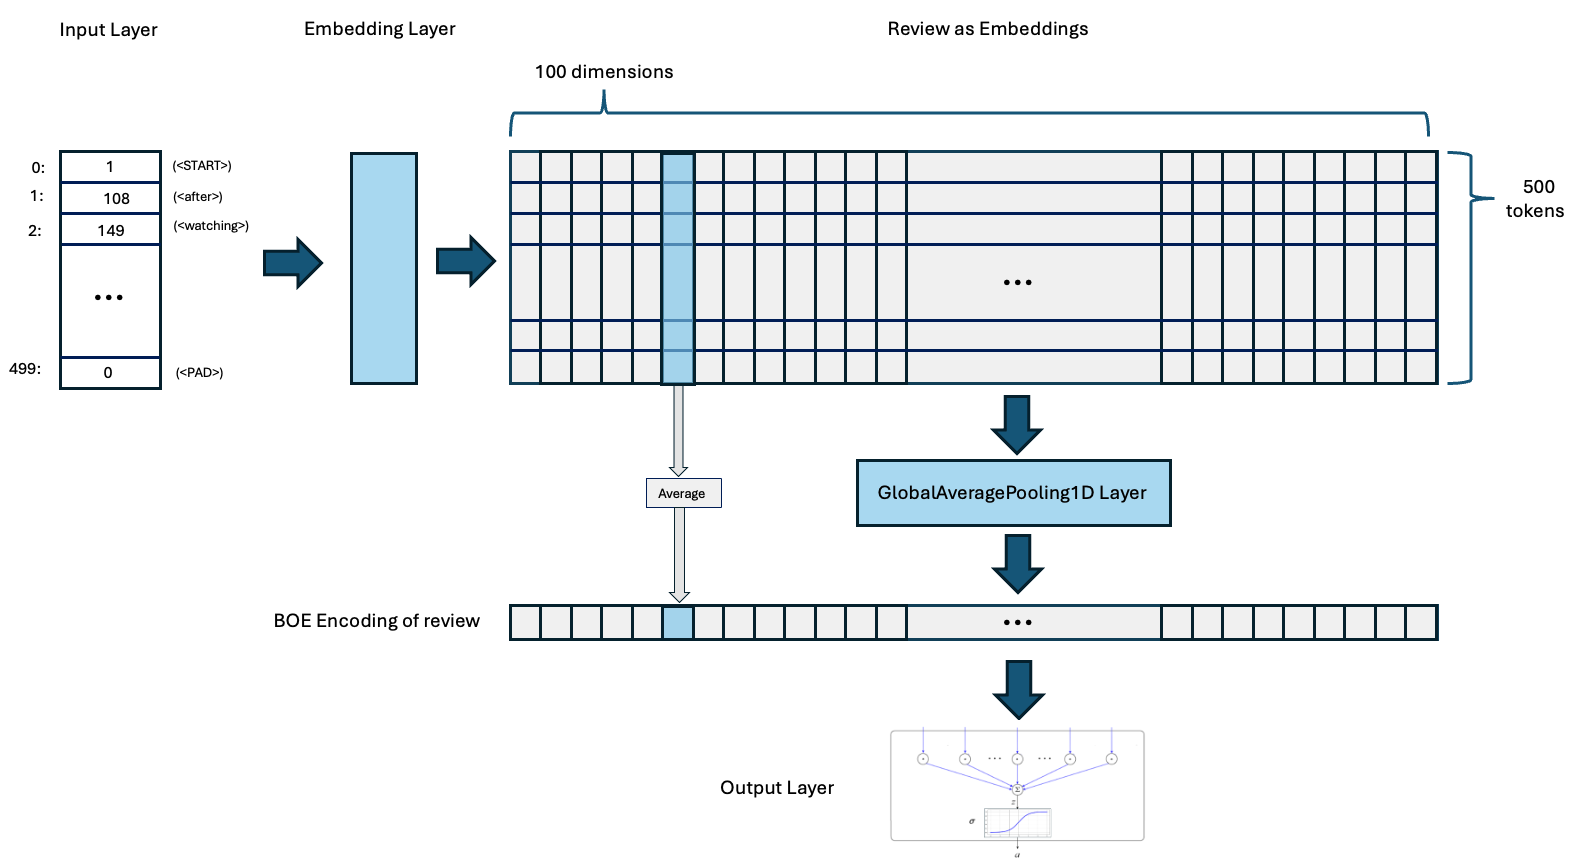

**Notes:**

- In Keras an Embedding layer has a trainable flag:

    - `trainable=False` (non-tunable or frozen)
    The `embedding_matrix` is a static lookup-table of embeddings trained on a 6-billion-token corpus, and does not adapt to your data.
    
    - `trainable=True` (tunable or fine-tuned)
    The `embedding_matrix` is initialized to the static embeddings  but then your training process updates those vectors via back-propagation on your task’s loss. Your model fine-tunes the embeddings to adapt to your specific dataset.


    This is exactly the same process as when we used pre-trained CNN models for image classification---except now the pretrained model is the word embeddings. 



- We'll use a static validation set consisting of 20% of the training set. 

In [32]:
def build_boe_model(trainable=False, learning_rate=1e-3):
    model = Sequential([
        Input(shape=(max_text_length,), dtype='int32'),   # each sample is a sequence of max_text_length integers, e.g., 500
        Embedding(
            input_dim  = training_vocabulary_size,  # e.g. 20_000
            output_dim = embedding_dimension,       # e.g. 100
            weights    = [embedding_matrix],
            mask_zero  = True                       # ignore <PAD> in pooling -- this makes a huge difference in training speed!
            trainable  = trainable                  # freeze or unfreeze embedding weights
        ),
        GlobalAveragePooling1D(),                        # take average along each dimension
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer = Adam( learning_rate = learning_rate ),
                  loss      = 'binary_crossentropy',
                  metrics   =['accuracy']
                 )
    
    return model

model =  build_boe_model()

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 500, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 100)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,101 (7.63 MB)

 Trainable params: 2,000,101 (7.63 MB)

 Non-trainable params: 0 (0.00 B)

#### Define two useful LR callbacks

In [33]:
# define a default EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,            # stop after 10 epochs with no val_loss improvement
    min_delta=1e-4,
    restore_best_weights=True,
    verbose=0
)

# Reduce the learning rate by half if val_loss does not improve for 3 epochs,
# but never go below 1e-6
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    min_delta=1e-4,
    factor=0.5,
    min_lr=1e-7,
    cooldown=0,             # Wait this many epochs before starting to monitor again
    verbose=0
)

#### Train and Report Results

In [34]:
def train_and_plot(model, title, epochs=50, callbacks=[], return_history=False, verbose=0):
    start_time = time.time()
    
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=128,
        callbacks=callbacks,
        verbose=verbose
    )

    plot_learning_curves(history,title=title)

    # evaluate on the held-out test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest Loss: {test_loss:.4f} — Test Accuracy: {test_acc:.4f}")

    print(f"Execution Time: " + format_hms(time.time()-start_time))

    if return_history:
        return history

lr: 0.001  epochs:  50  callbacks: [<keras.src.callbacks.early_stopping.EarlyStopping object at 0x3dc3c4a90>]
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 11.


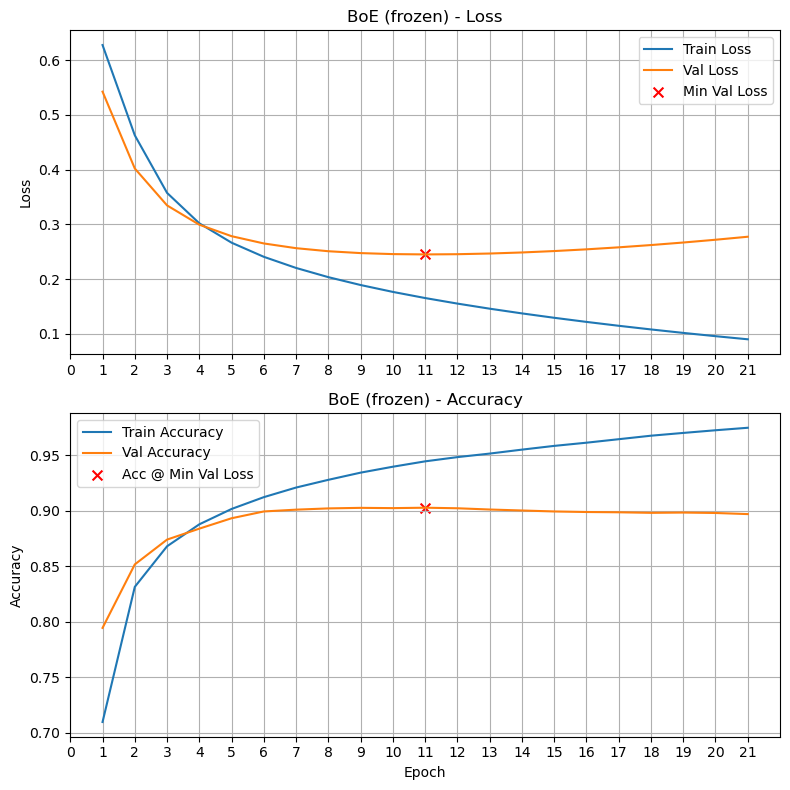

Final Training Loss:            0.0900
Final Training Accuracy:        0.9748
Final Validation Loss:          0.2773
Final Validation Accuracy:      0.8970
Minimum Validation Loss:        0.2450 (Epoch 11)
Validation Accuracy @ Min Loss: 0.9028

Test Loss: 0.2571 — Test Accuracy: 0.8985
Execution Time: 00:01:08


In [35]:
# Bag-of-Embeddings, frozen

lr = 1e-3                 
epochs = 50
callbacks=[early_stopping]

print(f"lr: {lr}  epochs:  {epochs}  callbacks: {callbacks}")

boe_frozen = build_boe_model(trainable=False, learning_rate=lr)  

train_and_plot(boe_frozen, title="BoE (frozen)",epochs=epochs,callbacks=callbacks, verbose=0)


lr: 0.001  epochs:  100  callbacks: [<keras.src.callbacks.early_stopping.EarlyStopping object at 0x3dc3c4a90>, <keras.src.callbacks.reduce_lr_on_plateau.ReduceLROnPlateau object at 0x3dc3c5570>]
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 11.


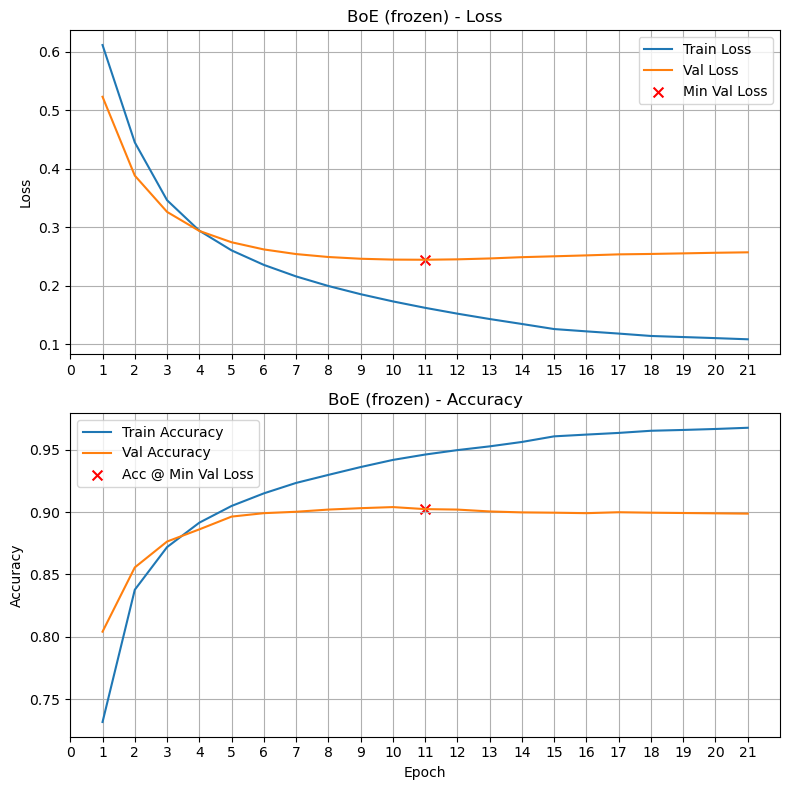

Final Training Loss:            0.1084
Final Training Accuracy:        0.9676
Final Validation Loss:          0.2570
Final Validation Accuracy:      0.8988
Minimum Validation Loss:        0.2443 (Epoch 11)
Validation Accuracy @ Min Loss: 0.9024

Test Loss: 0.2563 — Test Accuracy: 0.8990
Execution Time: 00:01:09


In [36]:
# Bag-of-Embeddings, frozen

lr = 1e-3                 
epochs = 100
callbacks=[early_stopping,reduce_lr]

print(f"lr: {lr}  epochs:  {epochs}  callbacks: {callbacks}")

boe_frozen = build_boe_model(trainable=False, learning_rate=lr)  

train_and_plot(boe_frozen, title="BoE (frozen)",epochs=epochs,callbacks=callbacks, verbose=0)